In [1]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sys
import pysm3.units as u
from pysm3 import utils
import os

import s4bi
import matplotlib.pyplot as plt
from importlib import reload
from scipy import constants
from astropy.cosmology import Planck15
import qubic
from qubic import mcmc
import healpy as hp
import numpy as np
import qubicplus
from qubic import NamasterLib as nam
from qubic import AnalysisMC as amc
from qubic import camb_interface as qc
import scipy
import pysm3
#import fgbuster
import fgbuster
center = qubic.equ2gal(0, -57)
from fgbuster.component_model import (CMB, Dust, Dust_2b, Synchrotron, AnalyticComponent)
from fgbuster import basic_comp_sep, get_instrument
# If there is not this command, the kernel shut down every time..
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pickle

# If there is not this command, the kernel shut down every time..
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### CMB-S4 config

freqs = np.array([20., 30., 40., 85., 95., 145., 155., 220., 270.])
bandwidth = np.array([5., 9., 12., 20.4, 22.8, 31.9, 34.1, 48.4, 59.4])
dnu_nu = bandwidth/freqs
beam_fwhm = np.array([11., 72.8, 72.8, 25.5, 25.5, 22.7, 22.7, 13., 13.])
mukarcmin_TT = np.array([16.5, 9.36, 11.85, 2.02, 1.78, 3.89, 4.16, 10.15, 17.4])
mukarcmin_EE = np.array([10.87, 6.2, 7.85, 1.34, 1.18, 1.8, 1.93, 4.71, 8.08])
mukarcmin_BB = np.array([10.23, 5.85, 7.4, 1.27, 1.12, 1.76, 1.89, 4.6, 7.89])
ell_min = np.array([30, 30, 30, 30, 30, 30, 30, 30, 30])
nside = np.array([512, 512, 512, 512, 512, 512, 512, 512, 512])
edges_min = freqs * (1. - dnu_nu/2)
edges_max = freqs * (1. + dnu_nu/2)
edges = [[edges_min[i], edges_max[i]] for i in range(len(freqs))]
s4_config = {
    'nbands': len(freqs),
    'frequency': freqs,
    'depth_p': 0.5*(mukarcmin_EE + mukarcmin_BB),
    'depth_i': mukarcmin_TT,
    'depth_e': mukarcmin_EE,
    'depth_b': mukarcmin_BB,
    'fwhm': beam_fwhm,
    'bandwidth': bandwidth,
    'dnu_nu': dnu_nu,
    'ell_min': ell_min,
    'nside': nside,
    'fsky': 0.03,
    'ntubes': 12,
    'nyears': 7.,
    'edges': edges,
    'effective_fraction': np.zeros(len(freqs))+1.
            }

import fgbuster as fgb
from fgbuster import basic_comp_sep, get_instrument, Dust, CMB


def separate(comp, instr, maps_to_separate, tol=1e-5, print_option=False):
    solver_options = {}
    solver_options['disp'] = False
    fg_args = comp, instr, maps_to_separate
    fg_kwargs = {'method': 'Nelder-Mead', 'tol': tol, 'options': solver_options}
    try:
        res = fgb.basic_comp_sep(*fg_args, **fg_kwargs)
    except KeyError:
        fg_kwargs['options']['disp'] = False
        res = fgb.basic_comp_sep(*fg_args, **fg_kwargs)
    if print_option:
        print()
        print("message:", res.message)
        print("success:", res.success)
        print("result:", res.x)
        
    return res



def fct_subopt(nus):
    subnus = [150., 220]
    subval = [1.4, 1.2]
    fct_subopt = np.poly1d(np.polyfit(subnus, subval, 1))
    return fct_subopt(nus)

subnus = [150., 220]
subval = [1.4, 1.2]

def get_coverage(fsky, nside, center_radec=[0., -57.]):
    center = qubic.equ2gal(center_radec[0], center_radec[1])
    uvcenter = np.array(hp.ang2vec(center[0], center[1], lonlat=True))
    uvpix = np.array(hp.pix2vec(nside, np.arange(12*nside**2)))
    ang = np.arccos(np.dot(uvcenter, uvpix))
    indices = np.argsort(ang)
    okpix = ang < -1
    okpix[indices[0:int(fsky * 12*nside**2)]] = True
    mask = np.zeros(12*nside**2)
    mask[okpix] = 1
    return mask

def qubicify(config, qp_nsub, qp_effective_fraction):
    nbands = np.sum(qp_nsubs)
    qp_config = config.copy()
    for k in qp_config.keys():
        qp_config[k]=[]
    qp_config['nbands'] = nbands
    qp_config['fsky'] = config['fsky']
    qp_config['ntubes'] = config['ntubes']
    qp_config['nyears'] = config['nyears']
    qp_config['initial_band'] = []

    for i in range(len(config['frequency'])):
        #print(config['edges'][i][0], config['edges'][i][-1])
        newedges = np.linspace(config['edges'][i][0], config['edges'][i][-1], qp_nsubs[i]+1)
        #print(newedges)
        newfreqs = (newedges[0:-1]+newedges[1:])/2
        newbandwidth = newedges[1:] - newedges[0:-1]
        newdnu_nu = newbandwidth / newfreqs
        newfwhm = config['fwhm'][i] * config['frequency'][i]/newfreqs
        scalefactor_noise = np.sqrt(qp_nsubs[i]) * fct_subopt(config['frequency'][i]) / qp_effective_fraction[i]
        newdepth_p = config['depth_p'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_i = config['depth_i'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_e = config['depth_e'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newdepth_b = config['depth_b'][i] * np.ones(qp_nsub[i]) * scalefactor_noise
        newell_min = np.ones(qp_nsub[i]) * config['ell_min'][i]
        newnside = np.ones(qp_nsub[i]) * config['nside'][i]
        neweffective_fraction = np.ones(qp_nsub[i]) * qp_effective_fraction[i]
        initial_band = np.ones(qp_nsub[i]) * config['frequency'][i]

        for k in range(qp_nsubs[i]):
            if qp_effective_fraction[i] != 0:
                qp_config['frequency'].append(newfreqs[k])
                if i >= 3:
                    qp_config['depth_p'].append(newdepth_p[k])
                    qp_config['depth_i'].append(newdepth_i[k])
                    qp_config['depth_e'].append(newdepth_e[k])
                    qp_config['depth_b'].append(newdepth_b[k])
                else:
                    qp_config['depth_p'].append(s4_config['depth_p'][i])
                    qp_config['depth_i'].append(s4_config['depth_i'][i])
                    qp_config['depth_e'].append(s4_config['depth_e'][i])
                    qp_config['depth_b'].append(s4_config['depth_b'][i])
                qp_config['fwhm'].append(newfwhm[k])
                qp_config['bandwidth'].append(newbandwidth[k])
                qp_config['dnu_nu'].append(newdnu_nu[k])
                qp_config['ell_min'].append(newell_min[k])
                qp_config['nside'].append(newnside[k])

                qp_config['effective_fraction'].append(neweffective_fraction[k])
                qp_config['initial_band'].append(initial_band[k])
        for k in range(qp_nsubs[i]+1):
            if qp_effective_fraction[i] != 0:
                qp_config['edges'].append(newedges[k])

        #qp_config['depth_p'][:3] = s4_config['depth_p'][:3]
        #qp_config['depth_i'][:3] = s4_config['depth_i'][:3]

    fields = ['frequency', 'depth_p', 'depth_i', 'depth_e', 'depth_b', 'fwhm', 'bandwidth',
              'dnu_nu', 'ell_min', 'nside', 'edges', 'effective_fraction', 'initial_band']
    for j in range(len(fields)):
        qp_config[fields[j]] = np.array(qp_config[fields[j]])

    return qp_config


covmap = get_coverage(0.03, nside=256)
thr = 0.1
mymask = (covmap > (np.max(covmap)*thr)).astype(int)
pixok = mymask > 0

In [2]:
qp_nsubs = np.array([1, 1, 1, 5, 5, 5, 5, 5, 5])
qp_effective_fraction = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])
qp_config=qubicify(s4_config, qp_nsubs, qp_effective_fraction)

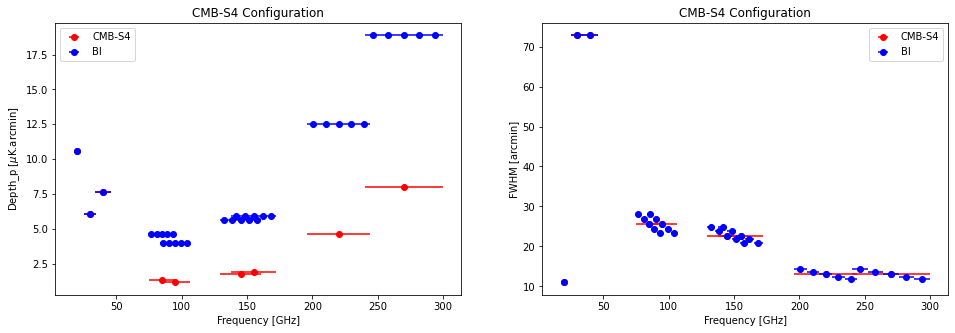

In [3]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.errorbar(s4_config['frequency'], s4_config['depth_p'], xerr=s4_config['bandwidth']/2, fmt='ro', label='CMB-S4')
plt.errorbar(qp_config['frequency'], qp_config['depth_p'], xerr=qp_config['bandwidth']/2, fmt='bo', label='BI')
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'Depth_p [$\mu$K.arcmin]')
plt.title('CMB-S4 Configuration')
plt.legend()
plt.subplot(1,2,2)
plt.errorbar(s4_config['frequency'], s4_config['fwhm'], xerr=s4_config['bandwidth']/2, fmt='ro', label='CMB-S4')
plt.errorbar(qp_config['frequency'], qp_config['fwhm'], xerr=qp_config['bandwidth']/2, fmt='bo', label='BI')
plt.xlabel('Frequency [GHz]')
plt.ylabel('FWHM [arcmin]')
plt.title('CMB-S4 Configuration')
plt.legend()
plt.show()

In [53]:
reload(qubicplus)

def get_instr(config, ref_fwhm):
    
    if config==qp_config:
        instr = get_instrument('Qubic+')
        ind_nu=15
        
    elif config==s4_config:
        instr = get_instrument('CMBS4')
        ind_nu=5
    else:
        raise TypeError('Choose QP or S4')
        
    instr.fwhm = np.ones(len(config['frequency']))*ref_fwhm*60
    
    return instr, ind_nu


def get_comp(sky, beta):
    comp=[]
    for indi, i in enumerate(sky.keys()):
        if i =='dust':
            comp.append(fgb.component_model.Dust_2b(nu0=beta[3], nubreak=beta[2], temp=20)) 
        elif i =='cmb':
            comp.append(fgb.component_model.CMB())
            
        elif i =='synchrotron':
            comp.append(fgb.component_model.Synchrotron(nu0=30))
        else:
            pass

    return comp
        
def compute_cl(lmin, delta_ell, nside, pixok, noise1, noise2, beam):
    maskpix = np.zeros(12*nside**2)
    maskpix[pixok] = 1
    Namaster = nam.Namaster(maskpix, lmin=lmin, lmax=2*nside-1, delta_ell=delta_ell)

    # Compute cross-spectra
    w=None
    leff, cl_noise, w = Namaster.get_spectra(noise1*np.sqrt(2),
                                             map2 = noise2*np.sqrt(2),
                                             purify_e=False,
                                             purify_b=True,
                                             w=w,
                                             verbose=False,
                                             beam_correction=beam,
                                             pixwin_correction=True)
    
    print(cl_noise.shape)

    return leff, cl_noise


def run_MC_separation(N, config, skyconfig, ref_fwhm, covmap, beta_in, lmin, dl):
    
    thr = 0
    mymask = (covmap > (np.max(covmap)*thr)).astype(int)
    pixok = mymask > 0
    
    clnoise=np.zeros((((N, 1, 16, 4))))
    
    skyconfig['cmb']=np.random.randint(10000000)
    
    for mc in range(N):
        
        print("##############")
        print("### i = {} ###".format(i))
        print("##############")
        
        beta_out=beta_in
        #print(beta_out)
        
        map1_2b, _, _ = qubicplus.BImaps(skyconfig, config).getskymaps(
                                                                    same_resol=ref_fwhm, 
                                                                    iib=False, 
                                                                    verbose=True, 
                                                                    coverage=covmap, 
                                                                    noise=True, 
                                                                    signoise=1.,
                                                                    beta=beta_out)
        
        map2_2b, _, _ = qubicplus.BImaps(skyconfig, config).getskymaps(
                                                                    same_resol=ref_fwhm, 
                                                                    iib=False, 
                                                                    verbose=True, 
                                                                    coverage=covmap, 
                                                                    noise=True, 
                                                                    signoise=1.,
                                                                    beta=beta_out)
        
        
        # Define instrument
        instr, ind_nu = get_instr(config, ref_fwhm)
        
        # Define component
        if beta_out is None:
            comp=[fgb.component_model.Dust(nu0=145, temp=20), fgb.component_model.CMB()]
        else:
            comp=get_comp(skyconfig, beta_out)
        
        res1=separate(comp, instr, map1_2b[:, :, pixok], tol=1e-6)
        res2=separate(comp, instr, map2_2b[:, :, pixok], tol=1e-6)
        
        print(res1.x)
        print(res2.x)
        
        # Isolate noise 
        newmap1_isolate=map1_2b[ind_nu].copy()
        newmap2_isolate=map2_2b[ind_nu].copy()
        for indj, j in enumerate(skyconfig.keys()):
            newmap1_isolate[:, pixok] -= res1.s[indj]
            newmap2_isolate[:, pixok] -= res2.s[indj]
            
        #print(newmap1_isolate.shape)
        
        # To make sure that coverage is respected
        newmap1_isolate[:, ~pixok]=0
        newmap2_isolate[:, ~pixok]=0
            
        
        leff, clnoise[mc, 0] = compute_cl(lmin, dl, 256, pixok, newmap1_isolate, newmap2_isolate, beam=ref_fwhm)
        
        
    return leff, clnoise

In [17]:
leff, cls4 = run_MC_separation(5, s4_config, {'dust':'d0', 'cmb':42}, 0.1, covmap, 
                                                               None, 40, 30)

    FWHM : [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01] deg 
    nus : [ 20.  30.  40.  85.  95. 145. 155. 220. 270.] GHz 
    Bandwidth : [ 5.   9.  12.  20.4 22.8 31.9 34.1 48.4 59.4] GHz


Model : d0 -> Spectral index beta is constant on the sky (set to 1.54)
Model : s0 -> Spectral index beta is constant on the sky (set to -3)
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 deg
    FWHM : [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01] deg 
    nus : [ 20.  30.  40.  85.  95. 145. 155. 220. 270.] GHz 
    Bandwidth : [ 5.   9.  12.  20.4 22.8 31.9 34.1 48.4 59.4] GHz


Model : d0 -> Spectral index beta is constant on the sky (set to 1.54)
Model : s0 -> Spectral index beta is constant on the sky (set to -3)
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 deg
Convolution to 0.01 

In [64]:
leff, clbi = run_MC_separation(10, qp_config, {'dust':'d0', 'cmb':42}, 0.5, covmap, 
                                                               None, 40, 30)

    FWHM : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5] deg 
    nus : [ 20.    30.    40.    76.84  80.92  85.    89.08  93.16  85.88  90.44
  95.    99.56 104.12 132.24 138.62 145.   151.38 157.76 141.36 148.18
 155.   161.82 168.64 200.64 210.32 220.   229.68 239.36 246.24 258.12
 270.   281.88 293.76] GHz 
    Bandwidth : [ 5.    9.   12.    4.08  4.08  4.08  4.08  4.08  4.56  4.56  4.56  4.56
  4.56  6.38  6.38  6.38  6.38  6.38  6.82  6.82  6.82  6.82  6.82  9.68
  9.68  9.68  9.68  9.68 11.88 11.88 11.88 11.88 11.88] GHz


Model : d0 -> Spectral index beta is constant on the sky (set to 1.54)
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 

Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
[1.54117845]
[1.53961668]
(16, 4)
    FWHM : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5] deg 
    nus : [ 20.    30. 

Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
    FWHM : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5] deg 
    nus : [ 20.    30.    40.    76.84  80.92  85.    89.08  93.16  85.88  90.44
  95.    99.56 104.12 132.24 138.62 145.   151.38 157.76 141.36 148.18
 155.   161.82 168.64 200.64 210.32 220.   229.68 239.36 246.24 258.12
 270.   281.88 293.76] GHz 
    Bandwidth : [ 5.    9.   12.    4.08  4.08  4.08  4.08  4.08  4.56  4.56  4.56  4.56
  4.56  6.38  6.38  6.38  6.38  6.38  6.82  6.82  6.82  6.82  6.82  9.68
  9.68  9.68  9.68  9.68 11.88 11.88 11.88 11.88 11.88] GHz


Model : d0 -> Spectral index beta is constant on the sky (set to 1.54)
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 

Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
Convolution to 0.50 deg
    FWHM : [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5] deg 
    nus : [ 20.    30.    40.    76.84  80.92  85.    89.

In [65]:
save=True

if save:
    mydict = {'leff':leff,
              'clbi':clbi}

    output = open('results/cl/cl_truebeta_ins1_lmin40_dl30_10reals_1.pkl', 'wb')
    pickle.dump(mydict, output)
    output.close()

# Likelihood

In [4]:
def plot_errors_lines(leff, err, dl, s, color='r', label=''):
    for i in range(len(leff)):
        if i==0:
            plt.plot([leff[i]-dl/2, leff[i]+dl/2], [err[i, i,s], err[i, i,s]],color, label=label)
        else:
            plt.plot([leff[i]-dl/2, leff[i]+dl/2], [err[i, i,s], err[i, i,s]],color)
        if i < (len(leff)-1):
            plt.plot([leff[i]+dl/2,leff[i]+dl/2], [err[i, i,s], err[i+1, i+1,s]], color)

def ana_likelihood(rv, leff, fakedata, errors, model, prior, 
                   mylikelihood=mcmc.LogLikelihood, covariance_model_funct=None, otherp=None):
    ll = mylikelihood(xvals=leff, yvals=fakedata, errors=errors, 
                            model = model, flatprior=prior, covariance_model_funct=covariance_model_funct)  

    like = np.zeros_like(rv)
    for i in range(len(rv)):
        like[i] = np.exp(ll([rv[i]]))
    cumint = scipy.integrate.cumtrapz(like, x=rv)
    cumint = cumint / np.max(cumint)
    onesigma = np.interp(0.68, cumint, rv[1:])
    if otherp:
        other = np.interp(otherp, cumint, rv[1:])
        return like, cumint, onesigma, other
    else:
        return like, cumint, onesigma


def explore_like(leff, mcl_noise, errors, lmin, dl, cc, rv, otherp=None,
                 cov=None, plotlike=False, plotcls=False, 
                 verbose=False, sample_variance=True, mytitle='', color=None, mylabel='',my_ylim=None):
    
#     print(lmin, dl, cc)
#     print(leff)
#     print(scl_noise[:,2])
    ### Create Namaster Object
    # Unfortunately we need to recalculate fsky for calculating sample variance
    nside = 256
    lmax = 2 * nside - 1
    if cov is None:
        Namaster = nam.Namaster(None, lmin=lmin, lmax=lmax, delta_ell=dl)
        Namaster.fsky = 0.018
    else:
        okpix = cov > (np.max(cov) * float(cc))
        maskpix = np.zeros(12*nside**2)
        maskpix[okpix] = 1
        Namaster = nam.Namaster(maskpix, lmin=lmin, lmax=lmax, delta_ell=dl)
    
#     print('Fsky: {}'.format(Namaster.fsky))
    lbinned, b = Namaster.get_binning(nside)

    ### Bibnning CambLib
#     binned_camblib = qc.bin_camblib(Namaster, '../../scripts/QubicGeneralPaper2020/camblib.pickle', 
#                                     nside, verbose=False)
    binned_camblib = qc.bin_camblib(Namaster, 'camblib.pkl', 
                                    nside, verbose=False)


    ### Redefine the function for getting binned Cls
    def myclth(ell,r):
        clth = qc.get_Dl_fromlib(ell, r, lib=binned_camblib, unlensed=False)[0]
        return clth
    allfakedata = myclth(leff, 0.)
    
    ### And we need a fast one for BB only as well
    def myBBth(ell, r):
        clBB = qc.get_Dl_fromlib(ell, r, lib=binned_camblib, unlensed=False, specindex=2)[0]
        return clBB

    ### Fake data
    fakedata = myBBth(leff, 0.)
    
    if sample_variance:
        covariance_model_funct = Namaster.knox_covariance
    else:
        covariance_model_funct = None
    if otherp is None:
        like, cumint, allrlim = ana_likelihood(rv, leff, fakedata, 
                                            errors, 
                                            myBBth, [[0,1]],
                                           covariance_model_funct=covariance_model_funct)
    else:
        like, cumint, allrlim, other = ana_likelihood(rv, leff, fakedata, 
                                            errors, 
                                            myBBth, [[0,1]],
                                           covariance_model_funct=covariance_model_funct, otherp=otherp)
    
    if plotcls:
        if plotlike:
            plt.subplot(1,2,1)
            if np.ndim(BBcov) == 2:
                errorstoplot = np.sqrt(np.diag(errors))
            else:
                errorstoplot = errors
        #plot(inputl, inputcl[:,2], 'k', label='r=0')
        plt.plot(leff, errorstoplot, label=mylabel+' Errors', color=color)
        plt.xlim(0,lmax)
        if my_ylim is None:
            plt.ylim(1e-4,1e0)
        else:
            plt.ylim(my_ylim[0], my_ylim[1])
        plt.yscale('log')
        plt.xlabel('$\\ell$')
        plt.ylabel('$D_\\ell$')
        plt.legend(loc='upper left')
    if plotlike:
        if plotcls:
            plt.subplot(1,2,2)
        p=plt.plot(rv, like/np.max(like), 
               label=mylabel+' $\sigma(r)={0:6.4f}$'.format(allrlim), color=color)
        plt.plot(allrlim+np.zeros(2), [0,1.2], ':', color=p[0].get_color())
        plt.xlabel('r')
        plt.ylabel('posterior')
        plt.legend(fontsize=8, loc='upper right')
        plt.xlim(0,0.1)
        plt.ylim(0,1.2)
        plt.title(mytitle)
    
    if otherp is None:
        return like, cumint, allrlim
    else:
        return like, cumint, allrlim, other

In [40]:
def read_file_from_CC(N, nb_exp, name, var, nb_est):
    cl=np.zeros((((N*nb_exp, 1, 16, 4))))
    arg_est = np.zeros((N*nb_exp, nb_est))
    
    for i in range(N):
        with open('results/cl/'+name+'{}.pkl'.format(i+1), 'rb') as f:
            data = pickle.load(f)
        cl[i*nb_exp:(i+1)*nb_exp]=data[var]
        arg_est[i*nb_exp:(i+1)*nb_exp]=data['arg_est']
    leff=data['leff']
    return leff, cl, arg_est

In [36]:
with open('results/cl/'+'cl_2beta_fwhm0.0_ins0_lmin40_dl30_5reals_'+'{}.pkl'.format(7), 'rb') as f:
            data = pickle.load(f)

In [37]:
data['arg_est']

array([[  1.44366825,   1.46435567, 213.58831143,  19.61773858],
       [  1.43313039,   1.44927516, 213.02168688,  20.45754862],
       [  1.45472479,   1.48139237, 209.15017428,  18.79255487],
       [  1.45515655,   1.48345203, 203.89518836,  18.64447081],
       [  1.44681983,   1.4713697 , 204.64518056,  19.23558755]])

# $\beta = 1.54$

In [68]:
#with open('results/cl/cl_truebeta_ins0_lmin40_dl30_100reals.pkl', 'rb') as f:
    #data = pickle.load(f)
#leff=data['leff']
#cls4=data['cls4']

leff, cls4, est = read_file_from_CC(18, 1, 'cl_truebeta_fwhm0.0_ins0_lmin40_dl30_1reals_', 'cl', 2)
#leff, cls4 = read_file_from_CC(3, 3, 'cl_truebeta_ins0_lmin40_dl30_3reals_', 'cl')

print("{} realizations".format(cls4.shape[0]))
print("Mean of beta : {:.6f}".format(np.mean(est, axis=0)[0]))
print("Mean of temp : {:.6f}".format(np.mean(est, axis=0)[1]))

18 realizations
Mean of beta : 1.538915
Mean of temp : 20.064184


In [69]:
scl_s4 = np.std(cls4, axis=0)
#scl_bi = np.std(clbi, axis=0)

#clbi_reshape = np.moveaxis(clbi, [1, 2, 3], [3, 1, 2])
cls4_reshape = np.moveaxis(cls4, [1, 2, 3], [3, 1, 2])

#print(clbi_reshape.shape)

covbin_s4, _ = amc.get_covcorr_patch(cls4_reshape, stokesjoint=True, doplot=False)
#covbin_bi, _ = amc.get_covcorr_patch(clbi_reshape, stokesjoint=True, doplot=False)

### BB sigmas
sclBB_s4 = scl_s4[0, :, 2]
#sclBB_bi = scl_bi[0, :, 2]

BBcov_s4 = covbin_s4[:, :, 2]
#BBcov_bi = covbin_bi[:, :, 2]

method='sigma'
if method=='sigma':
    to_use_s4 = sclBB_s4.copy()
    #to_use_bi = sclBB_bi.copy()
if method=='covariance':
    to_use_s4 = BBcov_s4.copy()
    #to_use_bi = BBcov_bi.copy()

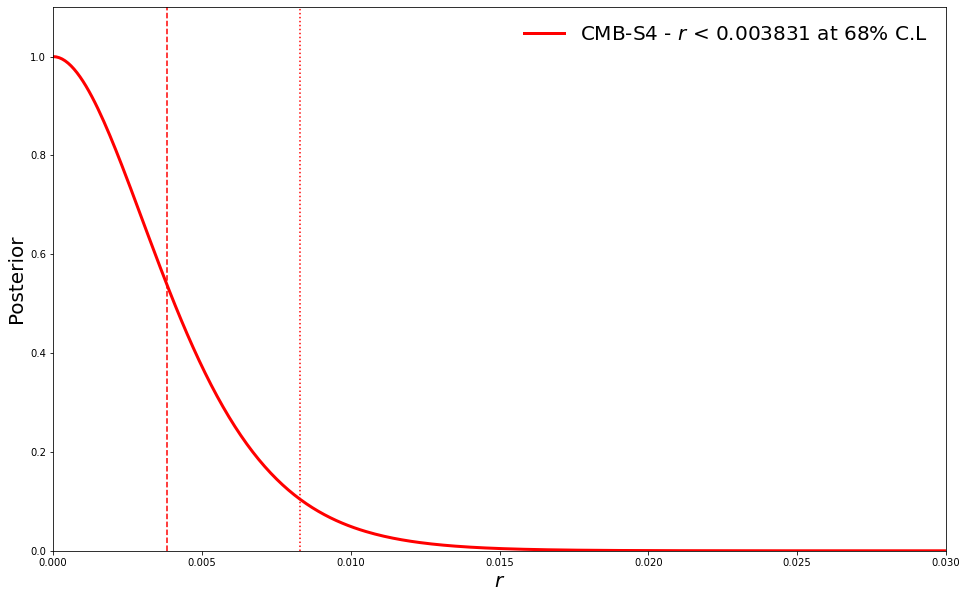

In [70]:
rv = np.linspace(0,0.1,1000)

lmin=40
delta_ell=30

like_s4, cumint_s4, rlim68_s4, rlim95_s4 = explore_like(leff, sclBB_s4, to_use_s4, lmin, delta_ell, 0, rv,
                                     cov=covmap, plotlike=False, plotcls=False,
                                     verbose=True, sample_variance=True, otherp=0.95)

#like_bi, cumint_bi, rlim68_bi, rlim95_bi = explore_like(leff, sclBB_bi, to_use_bi, lmin, delta_ell, 0.1, rv,
#                                     cov=covmap, plotlike=False, plotcls=False,
#                                     verbose=True, sample_variance=True, otherp=0.95)

plt.figure(figsize=(16, 10))
plt.plot(rv, like_s4, '-r', lw=3, label=r'CMB-S4 - $r$ < {:.6f} at 68% C.L'.format(rlim68_s4))
#plt.plot(rv, like_bi, '-b', lw=3, label=r'CMB-S4 - $r$ < {:.6f} at 68% C.L'.format(rlim68_bi))
plt.xlim(0, 0.03)
plt.ylim(0, 1.1)
plt.xlabel(r'$r$', fontsize=20)
plt.ylabel(r'Posterior', fontsize=20)
plt.axvline(rlim68_s4, color='red', ls='--')
plt.axvline(rlim95_s4, color='red', ls=':')
#plt.axvline(rlim68_bi, color='blue', ls='--')
plt.legend(fontsize=20,frameon=False)
plt.show()

# $\beta_0 = 1.44$ \| $\beta_1 = 1.64$ \| $nu_{break} = 265 \text{ GHz}$

In [71]:
leff, cls4_2b, est_2b = read_file_from_CC(18, 1, 'cl_2beta_fwhm0.0_ins0_lmin40_dl30_1reals_', 'cl', 4)

print("{} realizations".format(cls4_2b.shape[0]))
print("Mean of beta0 : {:.6f}".format(np.mean(est_2b, axis=0)[0]))
print("Mean of beta1 : {:.6f}".format(np.mean(est_2b, axis=0)[1]))
print("Mean of nubreak : {:.6f}".format(np.mean(est_2b, axis=0)[2]))
print("Mean of temp : {:.6f}".format(np.mean(est_2b, axis=0)[3]))

#with open('results/cl/cls4_2b_ins0_lmin40_dl30_100reals.pkl', 'rb') as f:
#    data = pickle.load(f)
    
#leff=data['leff']
#cls4_2b=data['cls4_2b']





18 realizations
Mean of beta0 : 1.444371
Mean of beta1 : 1.455533
Mean of nubreak : 210.729555
Mean of temp : 19.580355


In [72]:
scl_s4_2b = np.std(cls4_2b, axis=0)
#scl_bi = np.std(clbi, axis=0)

#clbi_reshape = np.moveaxis(clbi, [1, 2, 3], [3, 1, 2])
cls4_2b_reshape = np.moveaxis(cls4_2b, [1, 2, 3], [3, 1, 2])

#print(clbi_reshape.shape)

covbin_s4_2b, _ = amc.get_covcorr_patch(cls4_2b_reshape, stokesjoint=True, doplot=False)
#covbin_bi, _ = amc.get_covcorr_patch(clbi_reshape, stokesjoint=True, doplot=False)

### BB sigmas
sclBB_s4_2b = scl_s4_2b[0, :, 2]
#sclBB_bi = scl_bi[0, :, 2]

BBcov_s4_2b = covbin_s4_2b[:, :, 2]
#BBcov_bi = covbin_bi[:, :, 2]

method='sigma'
if method=='sigma':
    to_use_s4_2b = sclBB_s4_2b.copy()
    #to_use_bi = sclBB_bi.copy()
if method=='covariance':
    to_use_s4_2b = BBcov_s4_2b.copy()
    #to_use_bi = BBcov_bi.copy()

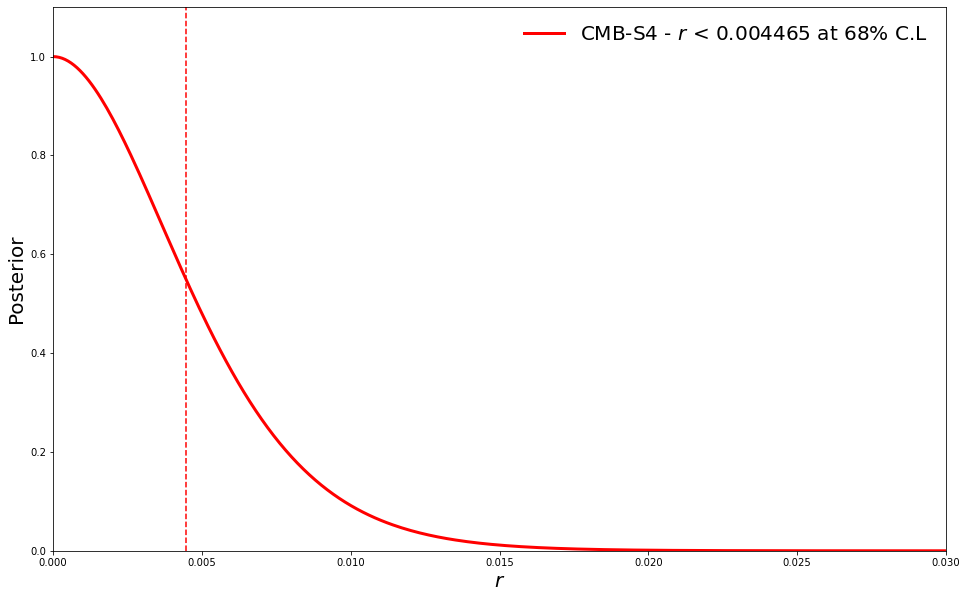

In [73]:
rv = np.linspace(0,0.1,1000)

lmin=40
delta_ell=30

like_s4_2b, cumint_s4_2b, rlim68_s4_2b, rlim95_s4_2b = explore_like(leff, sclBB_s4_2b, to_use_s4_2b, lmin, delta_ell, 0, rv,
                                     cov=covmap, plotlike=False, plotcls=False,
                                     verbose=True, sample_variance=True, otherp=0.95)

#like_bi, cumint_bi, rlim68_bi, rlim95_bi = explore_like(leff, sclBB_bi, to_use_bi, lmin, delta_ell, 0.1, rv,
#                                     cov=covmap, plotlike=False, plotcls=False,
#                                     verbose=True, sample_variance=True, otherp=0.95)

plt.figure(figsize=(16, 10))
plt.plot(rv, like_s4_2b, '-r', lw=3, label=r'CMB-S4 - $r$ < {:.6f} at 68% C.L'.format(rlim68_s4_2b))
plt.xlim(0, 0.03)
plt.ylim(0, 1.1)
plt.xlabel(r'$r$', fontsize=20)
plt.ylabel(r'Posterior', fontsize=20)
plt.axvline(rlim68_s4_2b, color='red', ls='--')
plt.legend(fontsize=20,frameon=False)
plt.show()